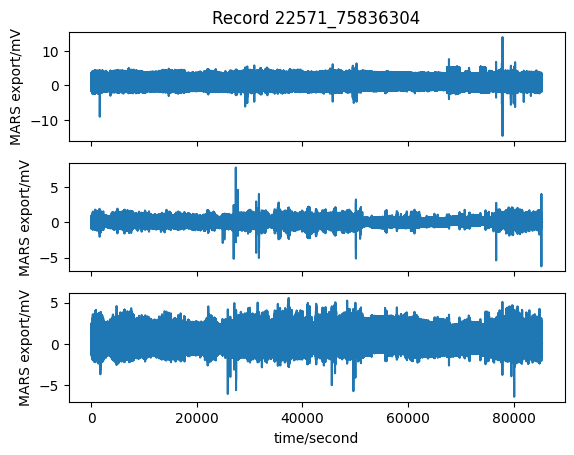

In [13]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# 레코드를 읽기
#record = wfdb.rdrecord('C:\\Users\\SNUH\\Desktop\\export\\23208_46643263')
record = wfdb.rdrecord('d:\\eee\\22571_75836304')
record

# 해당 레코드의 플롯 그리기
wfdb.plot.plot_wfdb(record=record, title='Record 22571_75836304')


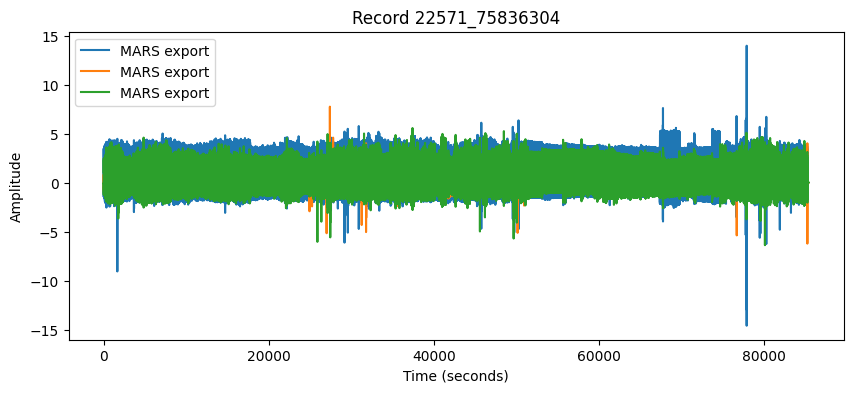

,MARS export,MARS export,MARS export
0,-0.12,0.06,-0.02
1,-0.10,0.08,-0.02
2,-0.08,0.08,-0.02
3,-0.08,0.08,-0.02
4,-0.10,0.08,-0.04
5,-0.10,0.08,-0.06
6,-0.08,0.08,-0.06
7,-0.08,0.08,-0.06
8,-0.08,0.12,-0.06
9,-0.06,0.16,-0.04


In [14]:
# 시간 벡터 생성
time = [i / record.fs for i in range(record.sig_len)]

# 플롯 생성
plt.figure(figsize=(10, 4))
for i in range(record.n_sig):
    plt.plot(time, record.p_signal[:, i], label=record.sig_name[i])
plt.legend()
plt.title('Record 22571_75836304')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# 레코드 데이터를 DataFrame으로 변환
df = pd.DataFrame(record.p_signal, columns=record.sig_name)
df.head(10)

In [9]:
record.p_signal

array([[-0.1 ,  0.08, -0.16],
       [-0.04,  0.06, -0.08],
       [ 0.06,  0.02, -0.02],
       ...,
       [ 0.02,  0.02,  0.  ],
       [ 0.04,  0.04,  0.  ],
       [ 0.04,  0.04,  0.06]])

In [4]:
# Transpose the DataFrame so columns represent channels
df_transposed = df.T

# Convert transposed DataFrame to XML
xml_elements = []
for channel, values in enumerate(df_transposed.values, start=1):
    signal_data = ','.join(map(str, values))
    xml_elements.append(f'<WaveformData lead="{channel}">{signal_data}</WaveformData>')

# Combine all XML elements
xml_string = "<data>\n" + "\n".join(xml_elements) + "\n</data>"

# Define the file path where you want to save the XML
xml_file_path = 'C:\\Users\\SNUH\\Desktop\\export\\4_73189235.xml'

# Write the XML string to the file
with open(xml_file_path, 'w', encoding='utf-8') as xml_file:
    xml_file.write(xml_string)

print(f"XML file has been saved to {xml_file_path}")

XML file has been saved to C:\Users\SNUH\Desktop\export\4_73189235.xml


In [6]:
import wfdb
import pandas as pd

# 레코드를 읽기
record_path = 'C:\\Users\\SNUH\\Desktop\\export\\4_73189235'
record = wfdb.rdrecord(record_path)

# 레코드 데이터를 DataFrame으로 변환
df = pd.DataFrame(record.p_signal, columns=record.sig_name)
# Transpose the DataFrame so columns represent channels
df_transposed = df.T

# Convert transposed DataFrame to XML
xml_elements = []
for channel, values in enumerate(df_transposed.values, start=1):
    signal_data = ','.join(map(str, values))
    xml_elements.append(f'<WaveformData lead="{channel}">{signal_data}</WaveformData>')

# Combine all XML elements
xml_string = "<data>\n" + "\n".join(xml_elements) + "\n</data>"

# Define the file path where you want to save the XML
xml_file_path = 'C:\\Users\\SNUH\\Desktop\\export\\4_73189235.xml'

# Write the XML string to the file
with open(xml_file_path, 'w', encoding='utf-8') as xml_file:
    xml_file.write(xml_string)

print(f"XML file has been saved to {xml_file_path}")

XML file has been saved to C:\Users\SNUH\Desktop\export\4_73189235.xml


In [2]:
import os
import re
import wfdb
import pandas as pd
import fitz  # PyMuPDF
from xml.etree.ElementTree import Element, SubElement, tostring, ElementTree
from xml.dom.minidom import parseString
import xml.etree.ElementTree as ET
from tqdm import tqdm

def process_pdf_files(pdf_dir, xml_dir):
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]
    for filename in tqdm(pdf_files, desc="Processing PDF Files"):
        pdf_path = os.path.join(pdf_dir, filename)
        pdf_doc = fitz.open(pdf_path)
        print(f"Processing file: {filename}, Total Pages: {pdf_doc.page_count}")

        page = pdf_doc.load_page(0)
        extracted_text = page.get_text()

        # XML 루트 요소 생성
        root = Element('HolterReport')

        # Parsing the text
        # patient_name = re.findall(r"HOLTER REPORT\n(.+)\nPatient Name:", extracted_text)[0]
        patient_id = re.findall(r"Patient Name:\n(\d+)\nID:", extracted_text)[0]
        hookup_date = re.findall(r"Medications:\n(\d+-\w+-\d+)\nHookup Date:", extracted_text)[0]
        hookup_time = re.findall(r"Hookup Date:\n(\d+:\d+:\d+)\nHookup Time:", extracted_text)[0]
        duration = re.findall(r"Hookup Time:\n(\d+:\d+:\d+)\nDuration:", extracted_text)[0]

        # Parsing General section
        general_section = re.search(r"General\n(.+?)Heart Rates", extracted_text, re.DOTALL).group(1)
        qrs_complexes = re.search(r"(\d+) QRS complexes", general_section).group(1)
        ventricular_beats = re.search(r"(\d+) Ventricular beats", general_section).group(1)
        supraventricular_beats = re.search(r"(\d+) Supraventricular beats", general_section).group(1)
        noise_percentage_match = re.search(r"(<\s*\d+|\d+) % of total time classified as noise", general_section)
        if noise_percentage_match:
            # "<" 기호와 숫자, 또는 숫자만 추출
            noise_percentage = noise_percentage_match.group(1)
        else:
            noise_percentage = "0"  # 일치하는 것이 없는 경우 기본값 설정

        # Constructing the XML
        patient_info = SubElement(root, 'PatientInfo')
        #SubElement(patient_info, 'Name').text = patient_name
        SubElement(patient_info, 'PID').text = patient_id
        SubElement(patient_info, 'HookupDate').text = hookup_date
        SubElement(patient_info, 'HookupTime').text = hookup_time
        SubElement(patient_info, 'Duration').text = duration

        # General
        general = SubElement(root, 'General')
        SubElement(general, 'QRScomplexes').text = qrs_complexes
        SubElement(general, 'VentricularBeats').text = ventricular_beats
        SubElement(general, 'SupraventricularBeats').text = supraventricular_beats
        SubElement(general, 'NoisePercentage').text = noise_percentage


        # Heart Rates section
        heart_rates = SubElement(root, 'HeartRates')
        patterns_hr = [
            (r"(\d+) Minimum at ([\d:]+ \d+-\w+)", 'MinimumRate', 'Timestamp'),
            (r"(\d+) Average", 'AverageRate', None),
            (r"(\d+) Maximum at ([\d:]+ \d+-\w+)", 'MaximumRate', 'Timestamp'),
            (r"(\d+) Beats in tachycardia \(>[0-9]+ bpm\), (\d+)% total", 'TachycardiaBeats', 'TachycardiaPercentage'),
            (r"(\d+) Beats in bradycardia \(<60 bpm\), (\d+)% total", 'BradycardiaBeats', 'BradycardiaPercentage'),
        ]

        for pattern, main_tag, sub_tag in patterns_hr:
            match = re.search(pattern, extracted_text)
            if match:
                if sub_tag:
                    element = SubElement(heart_rates, main_tag)
                    SubElement(element, sub_tag).text = match.group(2)
                    element.text = match.group(1)  # Main value
                else:
                    SubElement(heart_rates, main_tag).text = match.group(1)
                    
        max_rr_match = re.search(r"(\d+\.\d+) Seconds Max R-R at ([\d:]+ \d+-\w+)", extracted_text)
        if max_rr_match:
            max_rr = SubElement(heart_rates, 'SecondsMaxRR')
            SubElement(max_rr, 'Seconds').text = max_rr_match.group(1)
            SubElement(max_rr, 'Timestamp').text = max_rr_match.group(2)

                            
        # Ventriculars section extraction
        ventriculars_match = re.search(r"Ventriculars \(V, F, E, I\)\n([\s\S]+?)\nSupraventriculars \(S, J, A\)", extracted_text)
        if ventriculars_match:
            ventriculars_section = ventriculars_match.group(1)
        else:
            ventriculars_section = ""

        # Supraventriculars section extraction
        supraventriculars_match = re.search(r"Supraventriculars \(S, J, A\)\n([\s\S]+?)Interpretation", extracted_text)
        if supraventriculars_match:
            supraventriculars_section = supraventriculars_match.group(1)
        else:
            supraventriculars_section = ""

        # Regex patterns for Ventriculars and Supraventriculars
        ventriculars_patterns = [
            (r"(\d+) Isolated", ['Isolated']),
            (r"(\d+) Couplets", ['Couplets']),
            (r"(\d+) Bigeminal cycles", ['BigeminalCycles']),
            (r"(\d+) Runs totaling (\d+) beats", ['Runs', ('RunsDetails', 'TotalBeats')]),
            (r"(\d+) Beats longest run (\d+) bpm ([\d:]+ \d+-\w+)", [('LongestRun', 'Beats'), ('LongestRun', 'BPM'), ('LongestRun', 'Timestamp')]),
            (r"(\d+) Beats fastest run (\d+) bpm ([\d:]+ \d+-\w+)", [('FastestRun', 'Beats'), ('FastestRun', 'BPM'), ('FastestRun', 'Timestamp')])
        ]

        supraventriculars_patterns = [
            (r"(\d+) Isolated", ['Isolated']),
            (r"(\d+) Couplets", ['Couplets']),
            (r"(\d+) Bigeminal cycles", ['BigeminalCycles']),
            (r"(\d+) Runs totaling (\d+) beats", ['Runs', ('RunsDetails', 'TotalBeats')]),
            (r"(\d+) Beats longest run (\d+) bpm ([\d:]+ \d+-\w+)", [('LongestRun', 'Beats'), ('LongestRun', 'BPM'), ('LongestRun', 'Timestamp')]),
            (r"(\d+) Beats fastest run (\d+) bpm ([\d:]+ \d+-\w+)", [('FastestRun', 'Beats'), ('FastestRun', 'BPM'), ('FastestRun', 'Timestamp')])
        ]

        # Ventriculars section to add xml
        ventriculars_xml = ET.SubElement(root, "Ventriculars")
        for pattern, tags in ventriculars_patterns:
            match = re.search(pattern, ventriculars_section)
            if match:
                for tag_index, tag in enumerate(tags):
                    if isinstance(tag, tuple):  
                        parent_tag = ET.SubElement(ventriculars_xml, tag[0])
                        ET.SubElement(parent_tag, tag[1]).text = match.group(tag_index + 1)
                    else:
                        ET.SubElement(ventriculars_xml, tag).text = match.group(tag_index + 1)

        # Supraventriculars section to add xml
        supraventriculars_xml = ET.SubElement(root, "Supraventriculars")
        for pattern, tags in supraventriculars_patterns:
            match = re.search(pattern, supraventriculars_section)
            if match:
                for tag_index, tag in enumerate(tags):
                    if isinstance(tag, tuple):  
                        parent_tag = ET.SubElement(supraventriculars_xml, tag[0])
                        ET.SubElement(parent_tag, tag[1]).text = match.group(tag_index + 1)
                    else:
                        ET.SubElement(supraventriculars_xml, tag).text = match.group(tag_index + 1)

        xml_str = tostring(root, 'utf-8')
        parsed_str = parseString(xml_str)
        pretty_xml_str = parsed_str.toprettyxml(indent="   ")

        xml_filename = os.path.splitext(filename)[0] + '.xml'
        xml_file_path = os.path.join(xml_dir, xml_filename)

        with open(xml_file_path, "w") as xml_file:
            xml_file.write(pretty_xml_str)

        print(f"Processed {filename}, Saved XML file: {xml_file_path}")

def add_record_data_to_xml(record_dir, xml_dir):
    record_files = [f for f in os.listdir(record_dir) if f.endswith('.hea')]
    for record_file in tqdm(record_files, desc="Adding Record Data to XML"):
        record_path = os.path.join(record_dir, record_file[:-4])  # Remove .hea extension
        record = wfdb.rdrecord(record_path)
        df = pd.DataFrame(record.p_signal, columns=record.sig_name)
        df_transposed = df.T

        # Prepare XML elements
        data_element = ET.Element('data')
        for channel, values in enumerate(df_transposed.values, start=1):
            signal_data = ','.join(map(str, values))
            wave_form_data = ET.SubElement(data_element, 'WaveformData', lead=str(channel))
            wave_form_data.text = signal_data

        # Convert to string and add newline for formatting
        xml_string = ET.tostring(data_element, 'utf-8')
        pretty_xml_str = parseString(xml_string).toprettyxml(indent="  ")

        # Adjust formatting to add newline after <data> and before each <WaveformData>
        pretty_xml_str = pretty_xml_str.replace('><WaveformData', '>\n<WaveformData')
        pretty_xml_str = pretty_xml_str.replace('</WaveformData><', '</WaveformData>\n<')

        xml_filename = os.path.splitext(record_file)[0] + '.xml'
        xml_file_path = os.path.join(xml_dir, xml_filename)

        if os.path.exists(xml_file_path):
            # Load existing XML and append new data
            tree = ET.parse(xml_file_path)
            root = tree.getroot()

            # Parse the newly created XML string and append it
            new_data_element = ET.fromstring(pretty_xml_str)
            root.append(new_data_element)

            # Save back to file
            tree.write(xml_file_path, encoding='utf-8', xml_declaration=True)
            print(f"Added record data to {xml_file_path}")
        else:
            print(f"Warning: {xml_file_path} does not exist.")

def main():
    pdf_dir = 'C:\\Users\\SNUH\\Desktop\\export'
    xml_dir = os.path.join(pdf_dir, 'xml')

    if not os.path.exists(xml_dir):
        os.makedirs(xml_dir)

    print("Starting to process PDF files...")
    process_pdf_files(pdf_dir, xml_dir)
    print("Starting to add record data to XML...")
    add_record_data_to_xml(pdf_dir, xml_dir)

    print("Completed processing all files.")

if __name__ == "__main__":
    main()


Starting to process PDF files...


Processing PDF Files: 100%|██████████| 2/2 [00:00<00:00, 46.08it/s]


Processing file: 10012_72776667.pdf, Total Pages: 13
Processed 10012_72776667.pdf, Saved XML file: C:\Users\SNUH\Desktop\export\xml\10012_72776667.xml
Processing file: 10013_72159293.pdf, Total Pages: 12
Processed 10013_72159293.pdf, Saved XML file: C:\Users\SNUH\Desktop\export\xml\10013_72159293.xml
Starting to add record data to XML...


Adding Record Data to XML:  50%|█████     | 1/2 [00:15<00:15, 15.39s/it]

Added record data to C:\Users\SNUH\Desktop\export\xml\10012_72776667.xml


Adding Record Data to XML: 100%|██████████| 2/2 [00:30<00:00, 15.38s/it]

Added record data to C:\Users\SNUH\Desktop\export\xml\10013_72159293.xml
Completed processing all files.
